# SBERT Classfication using the sentance-transform library

The preprocessed dataset is loaded in using pandas library

In [12]:
import pandas as pd
#read the dataset, and name the columns     
df = pd.read_csv('questions_data_clean_stopword_lemma_v4.csv', header=0)


#display the structure of the dataframe
print(df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23873 entries, 0 to 23872
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Title                      23873 non-null  object
 1   Description                23873 non-null  object
 2   Creation Time              23873 non-null  object
 3   Link                       23873 non-null  object
 4   Clean_Text_Init            23873 non-null  object
 5   Clean_Text_Stopword        23873 non-null  object
 6   Clean_Text_Stopword_Lemma  23873 non-null  object
dtypes: object(7)
memory usage: 1.3+ MB
None


The three options of processed text content are the columns: Clean_Text_Init, Clean_Text_Stopword, Clean_Text_Stopword_Lemma.

For SBERT, it is recommend to to remove stopwords or lemmatise the text as it may change the way the transformer understands the text.

Therefore, the column Clean_Text_Init, will be used as the input to the pretrained transformer.

This is text that is cleaned by making it all lowercase, and removing code blocks, symbols, screenshots, and links. But without stopword removal or lemmatisation.

In [13]:
#sbert embedding method used with DBSCAN clustering
from sentence_transformers import SentenceTransformer
docs =df['Clean_Text_Init']
#use the pretrained model available on huggingface
model = SentenceTransformer('sentence-transformers/paraphrase-multilingual-mpnet-base-v2')
embeddings = model.encode(docs)

In [55]:
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score

total_points = embeddings.shape[0]

#iteratively try different eps values to compare clusters
for i in range(1,20):
    #using the cosine similarity metric and 10 samples minimum in each cluster 
    dbscan = DBSCAN(eps=0.1+0.01*i, min_samples=10, metric='cosine', n_jobs=-1)
    cluster_labels = dbscan.fit_predict(embeddings)
    
    num_noise = np.sum(cluster_labels == -1)
    num_assigned = total_points - num_noise
    number_of_clusters = len(set(cluster_labels))-1

    filtered_embeddings = embeddings[cluster_labels != -1]
    filtered_labels = cluster_labels[cluster_labels != -1]
    unique_clusters = np.unique(filtered_labels)

    silhouette = round(silhouette_score(filtered_embeddings, filtered_labels, metric='cosine'),2) if len(filtered_labels)!=0 else 0

    print(f"For EPS value: {round(0.1+0.01*i,2)}, They are {number_of_clusters} clusters, with {num_assigned} posts assigned. Silhouette Score: {silhouette:.2f}")

For EPS value: 0.11, They are 0 clusters, with 0 posts assigned. Silhouette Score: 0
For EPS value: 0.12, They are 0 clusters, with 0 posts assigned. Silhouette Score: 0
For EPS value: 0.13, They are 0 clusters, with 0 posts assigned. Silhouette Score: 0
For EPS value: 0.14, They are 0 clusters, with 0 posts assigned. Silhouette Score: 0
For EPS value: 0.15, They are 2 clusters, with 19 posts assigned. Silhouette Score: 0.1899999976158142
For EPS value: 0.16, They are 2 clusters, with 39 posts assigned. Silhouette Score: 0.6800000071525574
For EPS value: 0.17, They are 3 clusters, with 81 posts assigned. Silhouette Score: 0.6499999761581421
For EPS value: 0.18, They are 6 clusters, with 162 posts assigned. Silhouette Score: 0.5199999809265137
For EPS value: 0.19, They are 6 clusters, with 232 posts assigned. Silhouette Score: 0.4699999988079071
For EPS value: 0.2, They are 7 clusters, with 356 posts assigned. Silhouette Score: 0.3199999928474426
For EPS value: 0.21, They are 10 cluster

To choose the best dbscan paramters, the assignment requirements need to be considered.

There needs to be at least 100 posts assigned, with a miniumum of 10 posts per category. 

Additionally, a Silhouette score of greater than 0.5 is considered decently distint clustering

Therefore the best hbscan parameters are EPS value: 0.18, with 6 clusters having 162 posts assigned. Silhouette Score: 0.52.

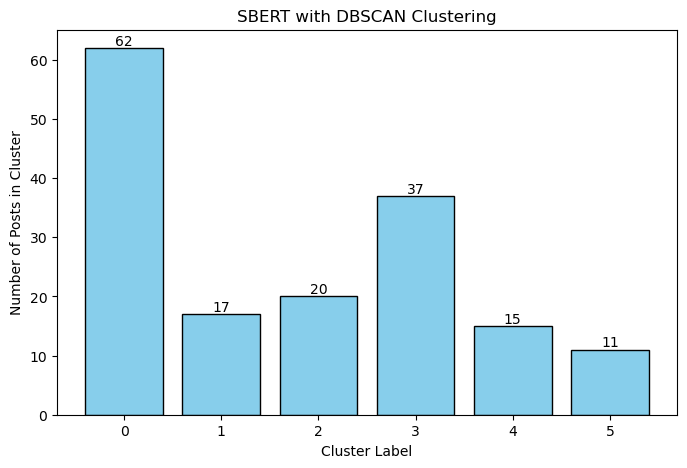

In [57]:
from sklearn.cluster import DBSCAN

#run the final sbert clustering
clustering = DBSCAN(eps=0.18, min_samples=10, metric='cosine').fit(embeddings)
cluster_labels = clustering.labels_

import matplotlib.pyplot as plt
import numpy as np
from collections import Counter 

clusters=[]
for i in cluster_labels:
    clusters.append(i)

unique_labels, counts = np.unique(clusters, return_counts=True)

plt.figure(figsize=(8, 5)) # Adjust figure size as needed
bars = plt.bar(unique_labels[1:], counts[1:], align='center', color='skyblue', edgecolor='black')
plt.bar_label(bars)
plt.xlabel("Cluster Label")
plt.ylabel("Number of Posts in Cluster")
plt.title("SBERT with DBSCAN Clustering")
plt.show()

In [58]:
clusters = {0:[],1:[],2:[],3:[],4:[],5:[],6:[],7:[],8:[],9:[],10:[],11:[],12:[],13:[],14:[],15:[],16:[],17:[],18:[],19:[]}

df['ClusterID'] = [-1] * len(df)

for label in sorted(unique_labels):
    # Find indices of sentences belonging to this cluster
    indices = np.where(cluster_labels == label)[0]
    num_in_cluster = len(indices)
    example_indices = indices[:]
    for i in example_indices:
        if label!=-1:
            clusters[label].append([df.at[i,'Title'],df.at[i,'Link']])
        df.at[i, 'ClusterID'] = label


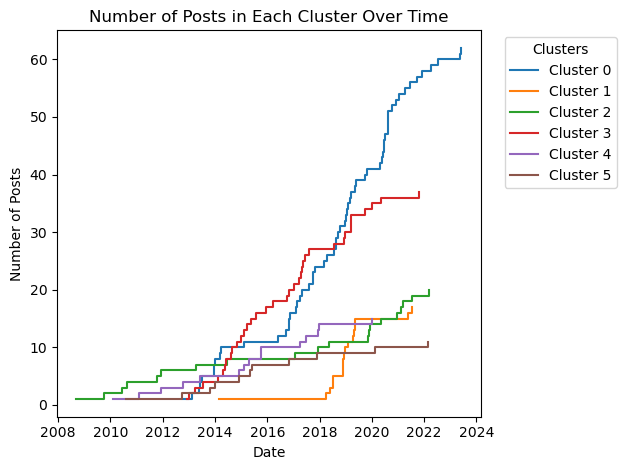

In [59]:
import seaborn as sns
#convert creation time column to pandas datetime type
df['Creation Time'] = pd.to_datetime(df['Creation Time'], format='mixed')
df=df.sort_values('Creation Time')
#for each cluster, create a time series line
for cluster_id in sorted(df['ClusterID'].unique()):
    if cluster_id!=-1:
        cluster_data = df[df['ClusterID'] == cluster_id]
        
        # Create cumulative count for this cluster
        dates = cluster_data['Creation Time']
        counts = range(1, len(cluster_data) + 1)
        plt.step(dates, counts, where='post', label=f'Cluster {cluster_id}')
plt.title('Number of Posts in Each Cluster Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.legend(title='Clusters', loc='upper left', bbox_to_anchor=(1.04, 1))

plt.tight_layout()
plt.show()


In [60]:
from sklearn.metrics import silhouette_score

filtered_embeddings = embeddings[cluster_labels != -1]
filtered_labels = cluster_labels[cluster_labels != -1]

unique_clusters = np.unique(filtered_labels)

silhouette_avg = silhouette_score(filtered_embeddings, filtered_labels, metric='cosine')

print(round(silhouette_avg,2))

0.52


In [62]:
import html
import random
random.seed(123)

data = clusters

#HTML table structure with CSS for basic styling
html_output = """
<style>
  table {
    border-collapse: collapse;
    width: 100%;
    font-family: sans-serif;
  }
  th, td {
    border: 1px solid #ddd;
    padding: 8px;
    text-align: left;
    vertical-align: top; /* Align content to the top */
  }
  th {
    background-color: #f2f2f2;
  }
  tr:nth-child(even) {
    background-color: #f9f9f9;
  }
  td[rowspan] {
    font-weight: bold;
    vertical-align: top; /* Align content to the top */
    text-align: center;     /* Center the key horizontally */
  }
  a {
    color: #0066cc;
    text-decoration: none;
  }
  a:hover {
    text-decoration: underline;
  }
</style>
<table>
  <thead>
    <tr>
      <th>Cluster</th>
      <th>Title</th>
      <th>URL</th>
    </tr>
  </thead>
  <tbody>
"""
#start table
for key, items in sorted(data.items()):
    sample_size = min(10, len(items)) #max 10 samples

    if sample_size > 0:
        sample = random.sample(items, sample_size) #random 10 examples
    else:
        sample = []

    rows= len(sample)
    for i, item in enumerate(sample):
        title = item[0] if len(item) > 0 else "N/A"
        url = item[1] if len(item) > 1 else "#"
        escaped_title = html.escape(title)
        escaped_url = html.escape(url)

        html_output += "<tr>"
        if i == 0:
            html_output += f'<td rowspan="{rows}">{key}</td>'
        html_output += f'<td>{escaped_title}</td>'
        html_output += f'<td><a href="{escaped_url}" target="_blank">{escaped_url}</a></td>'
        html_output += "</tr>\n"

html_output += """
  </tbody>
</table>
"""

try:
    with open('data_table_sampled.html', 'w', encoding='utf-8') as f:
        f.write(html_output)
    print("HTML table successfully saved to data_table_sampled.html")
except Exception as e:
    print(f"An error occurred while writing the file: {e}")

HTML table successfully saved to data_table_sampled.html
